In [1]:
# sklearn analytics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score

# Models
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import ensemble


# General
import warnings
import numpy as np
import pandas as pd
import random
import os
import re
import string
import statsmodels.api as sm
from os import path
from PIL import Image
from time import time
from sklearn import utils
!pip install kaggle --upgrade

# Warnings
warnings.filterwarnings('ignore')

from google.colab import drive, files
drive.mount('/content/gdrive', force_remount=True)

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.2)
Mounted at /content/gdrive


In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [3]:
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [4]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2595           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      10025           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4110           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         33           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2320           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2895           False  
LANL-Ear

In [5]:
!kaggle competitions files -c tmdb-box-office-prediction

name                   size  creationDate         
---------------------  ----  -------------------  
sample_submission.csv  60KB  2019-02-06 22:30:31  
train.csv              27MB  2019-02-06 22:32:02  
test.csv               40MB  2019-02-06 22:32:20  


In [6]:
!kaggle competitions download  -c tmdb-box-office-prediction \
-p '/content/My Drive/Data Science/Kaggle/box_office'

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


# **Data Cleaning**

In [7]:
# Read and Peak at Data
import pandas as pd
df = pd.read_csv(
    '/content/My Drive/Data Science/Kaggle/box_office/train.csv.zip', 
    compression='zip', header=0, sep=',', quotechar='"')

# Extracting Missing Count and Unique Count by Column
unique_count = []
for x in df.columns:
    unique_count.append([x, len(df[x].unique()), df[x].isnull().sum()])

# Missing Values
print("Missing Values: {}".format(df.isnull().sum().sum()))

# Data Dimensions
print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))

## Release Date is a string, converting it to pd.datetime ##
df['release_date'] = pd.to_datetime(df['release_date'])

# Creat new features with just the month and year
df['month'] = df['release_date'].map(lambda x: x.month)
df['year'] = df['release_date'].map(lambda x: x.year)

## Check Our Work ##
df.head()

Missing Values: 5601
Dataframe Dimension: 3000 Rows, 23 Columns


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,month,year
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,2,2015
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,8,2004
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,10,2014
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,3,2012
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,2,2009


In [8]:
print(df.columns)

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'month', 'year'],
      dtype='object')


To start simply, I'm going to make a copy of the data frame that drops the dictionaries and values that don't inherently seem useful.

In [9]:
columns_to_drop = ['belongs_to_collection', 'genres', 'homepage',
       'imdb_id', 'original_title',
       'poster_path', 'production_companies',
       'production_countries', 'release_date', 'spoken_languages',
       'status', 'tagline', 'Keywords', 'cast', 'crew'] 
df_simp = df.drop(columns_to_drop, axis=1)
df_simp.head()

,id,budget,original_language,overview,popularity,runtime,title,revenue,month,year
0,1,14000000,en,"When Lou, who has become the ""father of the In...",6.575393,93.0,Hot Tub Time Machine 2,12314651,2,2015
1,2,40000000,en,Mia Thermopolis is now a college graduate and ...,8.248895,113.0,The Princess Diaries 2: Royal Engagement,95149435,8,2004
2,3,3300000,en,"Under the direction of a ruthless instructor, ...",64.299990,105.0,Whiplash,13092000,10,2014
3,4,1200000,hi,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,122.0,Kahaani,16000000,3,2012
4,5,0,ko,Marine Boy is the story of a former national s...,1.148070,118.0,Marine Boy,3923970,2,2009


In [10]:
# Missing Values
print("Missing Values: {}".format(df_simp.isnull().sum().sum()))

# Data Dimensions
print("Dataframe Dimension: {} Rows, {} Columns".format(*df_simp.shape))

Missing Values: 10
Dataframe Dimension: 3000 Rows, 10 Columns


In [11]:
df_simp.describe()

,id,budget,popularity,runtime,revenue,month,year
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03,3000.000000,3000.000000
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07,6.775333,2004.579667
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08,3.409115,15.480790
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00,1.000000,1969.000000
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06,4.000000,1995.000000
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07,7.000000,2006.000000
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07,10.000000,2012.000000
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09,12.000000,2068.000000


In [12]:
# Fill zeroes in budget with mean
mean_budget = df_simp.budget.mean(skipna=True)
df_simp['budget'] = df_simp.budget.mask(
    df_simp.budget == 0, mean_budget)
df_simp['budget'] = df_simp.budget.fillna(mean_budget).astype(int)

# Fill zeroes in runtime with mean
mean_runtime = df_simp.runtime.mean(skipna=True)
df_simp['runtime'] = df_simp.runtime.mask(
    df_simp.runtime == 0, mean_runtime)
df_simp['runtime'] = df_simp.runtime.fillna(mean_runtime).astype(int)

df_simp.head()

,id,budget,original_language,overview,popularity,runtime,title,revenue,month,year
0,1,14000000,en,"When Lou, who has become the ""father of the In...",6.575393,93,Hot Tub Time Machine 2,12314651,2,2015
1,2,40000000,en,Mia Thermopolis is now a college graduate and ...,8.248895,113,The Princess Diaries 2: Royal Engagement,95149435,8,2004
2,3,3300000,en,"Under the direction of a ruthless instructor, ...",64.299990,105,Whiplash,13092000,10,2014
3,4,1200000,hi,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,122,Kahaani,16000000,3,2012
4,5,22531334,ko,Marine Boy is the story of a former national s...,1.148070,118,Marine Boy,3923970,2,2009


In [13]:
# Missing Values
print("Missing Values: {}".format(df_simp.isnull().sum().sum()))

# Data Dimensions
print("Dataframe Dimension: {} Rows, {} Columns".format(*df_simp.shape))

Missing Values: 8
Dataframe Dimension: 3000 Rows, 10 Columns


In [14]:
# Drop remaining rows with missing data
# as it represents < 3% of the data

df_simp = df_simp.dropna()

# Missing Values
print("Missing Values: {}".format(df_simp.isnull().sum().sum()))

# Data Dimensions
print("Dataframe Dimension: {} Rows, {} Columns".format(*df_simp.shape))

Missing Values: 0
Dataframe Dimension: 2992 Rows, 10 Columns


We have many features in the data, so first I will separate out the continuous variables. We want to make sure there are no missing values, and then we will check for outliers. 

# **Continuous Variable EDA and Feature Creation**

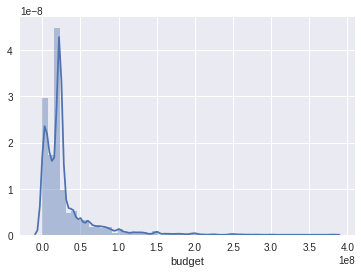

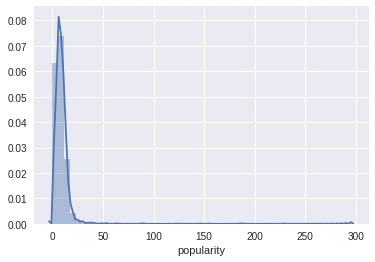

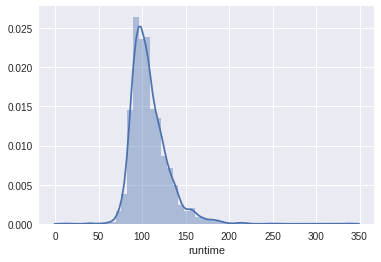

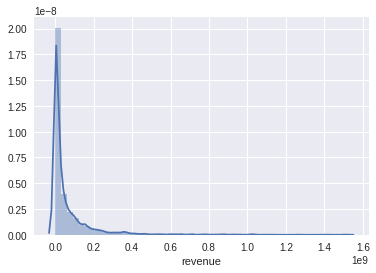

In [15]:
#Examining the distributions of continuous variables 
sns.distplot(df_simp.budget)
plt.show()
sns.distplot(df_simp.popularity)
plt.show()
sns.distplot(df_simp.runtime.round())
plt.show()
sns.distplot(df_simp.revenue)
plt.show()

We have some skewed variables. Let's investigate a few transformations and see if we can get a Gaussian distribution.

In [16]:
#Creating Transformed Variables
df_simp['budget'] = df_simp.budget.astype(int)
df_simp['log_budget'] = np.log(df_simp.budget)

df_simp['log_revenue'] = np.log(df_simp.revenue)

df_simp['log_popularity'] = np.log(df_simp.popularity)

df_simp.head(10)

,id,budget,original_language,overview,popularity,runtime,title,revenue,month,year,log_budget,log_revenue,log_popularity
0,1,14000000,en,"When Lou, who has become the ""father of the In...",6.575393,93,Hot Tub Time Machine 2,12314651,2,2015,16.454568,16.326300,1.883334
1,2,40000000,en,Mia Thermopolis is now a college graduate and ...,8.248895,113,The Princess Diaries 2: Royal Engagement,95149435,8,2004,17.504390,18.370959,2.110079
2,3,3300000,en,"Under the direction of a ruthless instructor, ...",64.299990,105,Whiplash,13092000,10,2014,15.009433,16.387512,4.163559
3,4,1200000,hi,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,122,Kahaani,16000000,3,2012,13.997832,16.588099,1.155287
4,5,22531334,ko,Marine Boy is the story of a former national s...,1.148070,118,Marine Boy,3923970,2,2009,16.930418,15.182614,0.138082
5,6,8000000,en,"Pinocchio and his friends, a glow worm and a m...",0.743274,83,Pinocchio and the Emperor of the Night,3261638,8,1987,15.894952,14.997740,-0.296691
6,7,14000000,en,A young girl buys an antique box at a yard sal...,7.286477,92,The Possession,85446075,8,2012,16.454568,18.263396,1.986020
7,8,22531334,en,A chronicle which provides a rare window into ...,1.949044,84,Control Room,2586511,1,2004,16.930418,14.765820,0.667339
8,9,22531334,en,After telling the story of Flint's last journe...,6.902423,100,Muppet Treasure Island,34327391,2,1996,16.930418,17.351454,1.931873
9,10,6000000,en,"In ""A Mighty Wind"", director Christopher Guest...",4.672036,91,A Mighty Wind,18750246,4,2003,15.607270,16.746717,1.541595


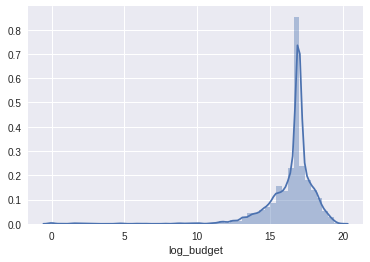

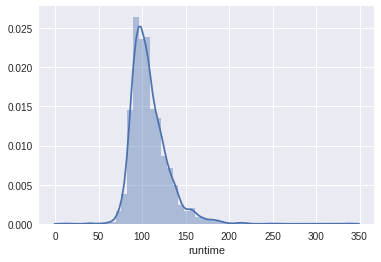

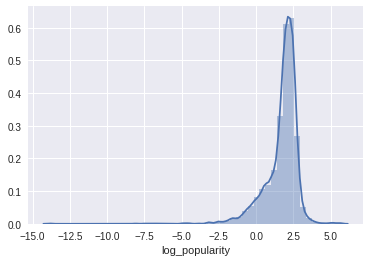

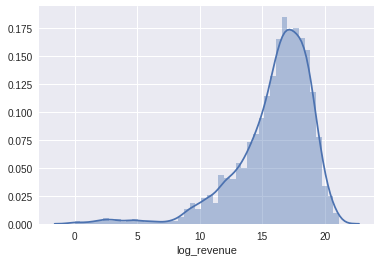

In [17]:
#Examining the distributions of continuous variables 
sns.distplot(df_simp.log_budget)
plt.show()
sns.distplot(df_simp.runtime)
plt.show()
sns.distplot(df_simp.log_popularity)
plt.show()
sns.distplot(df_simp.log_revenue)
plt.show()

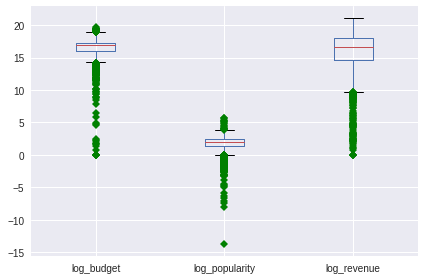

In [18]:
# Checking for outliers in the continuous variables
green_diamond = dict(markerfacecolor='g', marker='D')

# Split variables for better axis sharing
boxplot = df_simp.boxplot(
    column=['log_budget', 'log_popularity', 'log_revenue'], 
                     showfliers=True, flierprops=green_diamond)
plt.tight_layout()
plt.show()

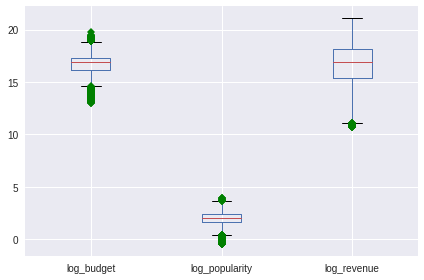

In [19]:
# Code to remove outliers
df_simp = df_simp[
    np.abs(
        df_simp.log_budget-df_simp.log_budget.mean(
        )) <= (2*df_simp.log_budget.std())]
df_simp = df_simp[
    np.abs(
        df_simp.log_popularity-df_simp.log_popularity.mean(
        )) <= (2*df_simp.log_popularity.std())]
df_simp = df_simp[np.abs(
    df_simp.log_revenue-df_simp.log_revenue.mean(
    )) <= (2*df_simp.log_revenue.std())]

# Split variables for better axis sharing
boxplot = df_simp.boxplot(
    column=['log_budget', 'log_popularity', 'log_revenue'], 
                     showfliers=True, flierprops=green_diamond)
plt.tight_layout()
plt.show()

In [20]:
# Missing Values
print("Missing Values: {}".format(df_simp.isnull().sum().sum()))

# Data Dimensions
print("Dataframe Dimension: {} Rows, {} Columns".format(*df_simp.shape))

Missing Values: 0
Dataframe Dimension: 2655 Rows, 13 Columns


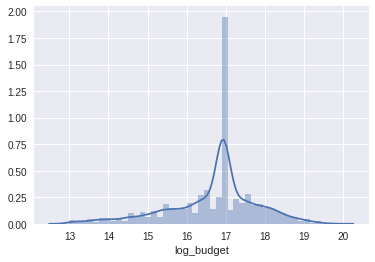

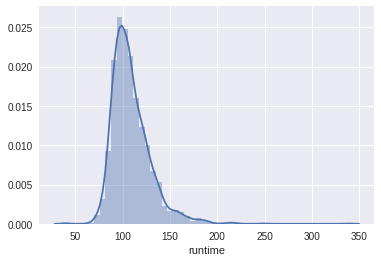

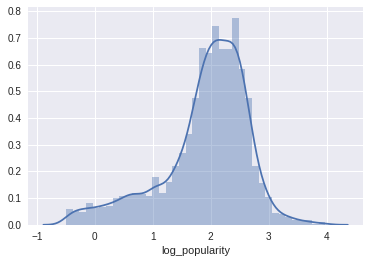

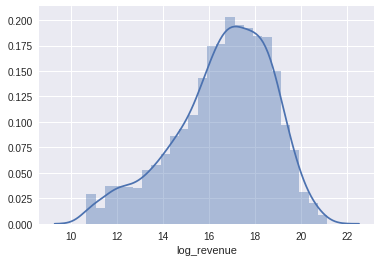

In [21]:
#Examining the distributions of continuous variables 
sns.distplot(df_simp.log_budget)
plt.show()
sns.distplot(df_simp.runtime)
plt.show()
sns.distplot(df_simp.log_popularity)
plt.show()
sns.distplot(df_simp.log_revenue)
plt.show()

We now have more Gaussian distributions for the continuous variables. 


                      id    budget  popularity   runtime   revenue     month  \
id              1.000000  0.018704   -0.003502  0.018749  0.000562  0.019292   
budget          0.018704  1.000000    0.400856  0.200820  0.727866  0.029664   
popularity     -0.003502  0.400856    1.000000  0.153167  0.512381  0.037648   
runtime         0.018749  0.200820    0.153167  1.000000  0.208786  0.170940   
revenue         0.000562  0.727866    0.512381  0.208786  1.000000  0.035483   
month           0.019292  0.029664    0.037648  0.170940  0.035483  1.000000   
year           -0.005238  0.039221    0.082560  0.131721  0.024369 -0.009433   
log_budget      0.004453  0.750724    0.300865  0.133501  0.473959  0.035351   
log_revenue     0.001042  0.482681    0.490111  0.185340  0.620074  0.044130   
log_popularity  0.003494  0.314623    0.864735  0.109489  0.381489  0.035354   

                    year  log_budget  log_revenue  log_popularity  
id             -0.005238    0.004453     0.001042  

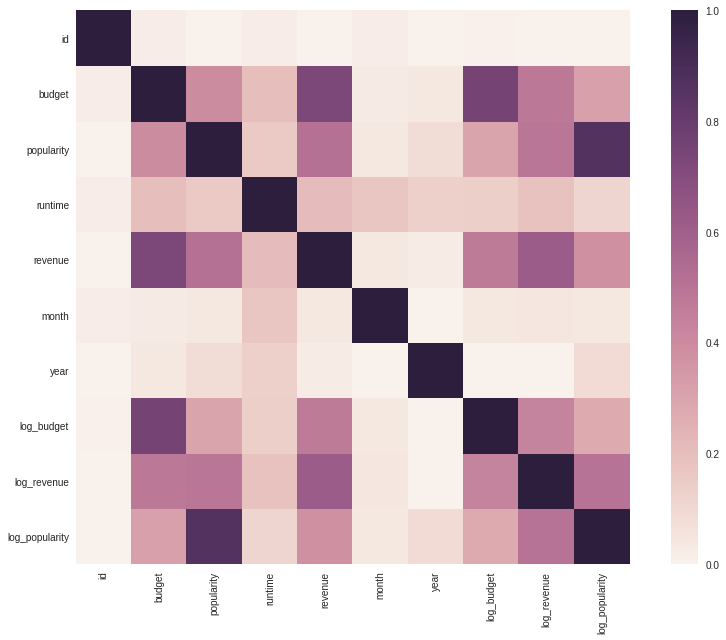

In [22]:
# Making correlation matrix.


corrmat = df_simp.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=1, vmin=0, square=True)
plt.tight_layout()
#plt.savefig('.png', dpi=300)
plt.show()

In [23]:
df_simp.columns

Index(['id', 'budget', 'original_language', 'overview', 'popularity',
       'runtime', 'title', 'revenue', 'month', 'year', 'log_budget',
       'log_revenue', 'log_popularity'],
      dtype='object')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


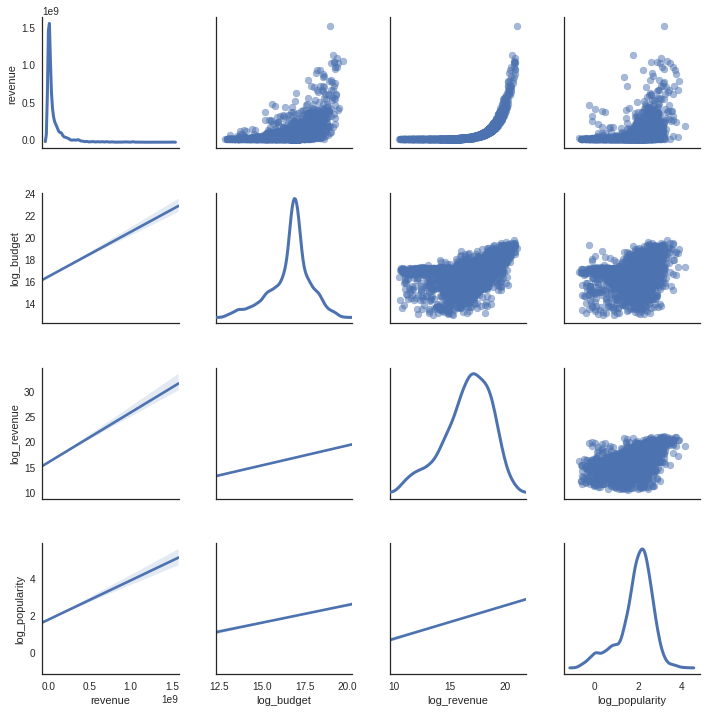

In [24]:
# Make the scatterplot matrix

# Set the default plot aesthetics to be prettier.
sns.set_style("white")

cont_var = df_simp
to_drop2 = ['id', 'budget', 'original_language', 'overview', 'popularity',
       'runtime', 'title', 'month', 'year']
cont_var = cont_var.drop(to_drop2, axis=1)

# Make a copy of the data to add jitter to and plot.
df_jittered = cont_var.loc[:, :].dropna()

# Making the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(df_jittered.shape)),
    columns=df_jittered.columns
)
# Combine the data and the noise.
df_jittered = df_jittered.add(jitter)

# Make a scatterplot matrix.
g = sns.PairGrid(df_jittered.dropna(), diag_sharey=False)

# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)

# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.tight_layout()
#plt.savefig('.png', dpi=200)
plt.show()

# **Categorical Variable EDA**

In [25]:
df_simp.columns

Index(['id', 'budget', 'original_language', 'overview', 'popularity',
       'runtime', 'title', 'revenue', 'month', 'year', 'log_budget',
       'log_revenue', 'log_popularity'],
      dtype='object')

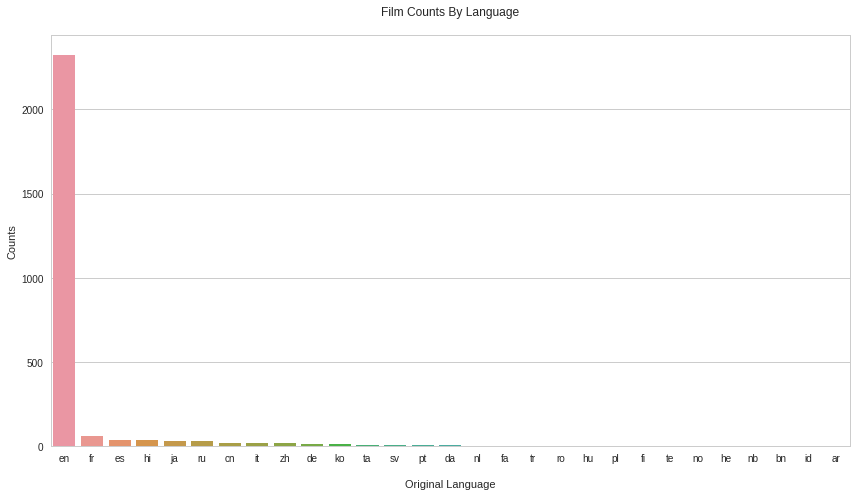

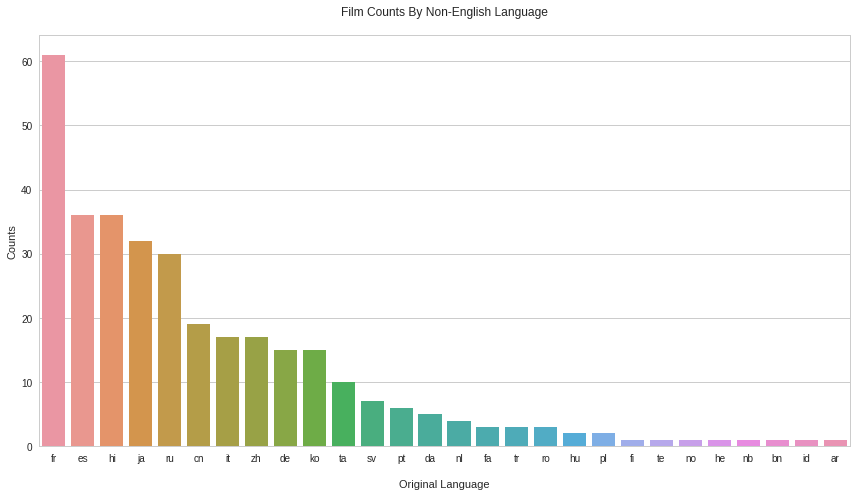

In [26]:
# Exploring film counts by original language
z = df_simp.groupby(by=['original_language'], as_index=False).count(
).sort_values(by='id', ascending=False)

# Plotting
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")
ax = sns.barplot(x=z['original_language'], y=z['id'], data=z)
plt.xlabel("\nOriginal Language")
plt.ylabel("Counts")
plt.title("Film Counts By Language\n")
#plt.savefig("Counts By Language.png", dpi =300)
plt.tight_layout()
plt.show()

# Showing all languages that are not English
df_foreign = df_simp[(df_simp['original_language'] != 'en')]

z = df_foreign.groupby(by=['original_language'], as_index=False).count(
).sort_values(by='revenue', ascending=False)

# Plotting
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")
ax = sns.barplot(x=z['original_language'], y=z['id'], data=z)
plt.xlabel("\nOriginal Language")
plt.ylabel("Counts")
plt.title("Film Counts By Non-English Language\n")
#plt.savefig("Counts By Language.png", dpi =300)
plt.tight_layout()
plt.show()

English original language films make up the overwhelming majority of the data. This feature may skew the results of any modeling.

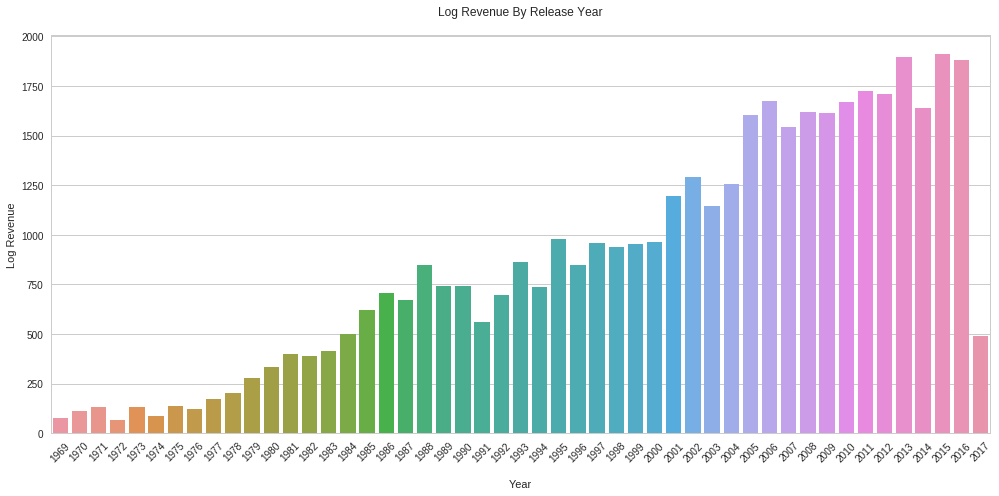

In [27]:
# Exploring film counts released per year

# We need to remove unreleased films
df_released = df_simp[(df_simp['year'] <= 2017)]

z = df_released.groupby(by=['year'], as_index=False).sum()

plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")
ax = sns.barplot(x=z['year'], y=z['log_revenue'], data=z)
plt.xlabel("\nYear")
plt.xticks(rotation=45)
plt.ylabel("Log Revenue")
plt.title("Log Revenue By Release Year\n")
plt.tight_layout()
#plt.savefig("Counts By Language.png", dpi =300)
plt.show()

We can see that theatrical releases for films have increased earned revenue at a relatively steady rate. We do see that 2017 appears to have incomplete data. It may be worth dropping that year when we move to modeling.

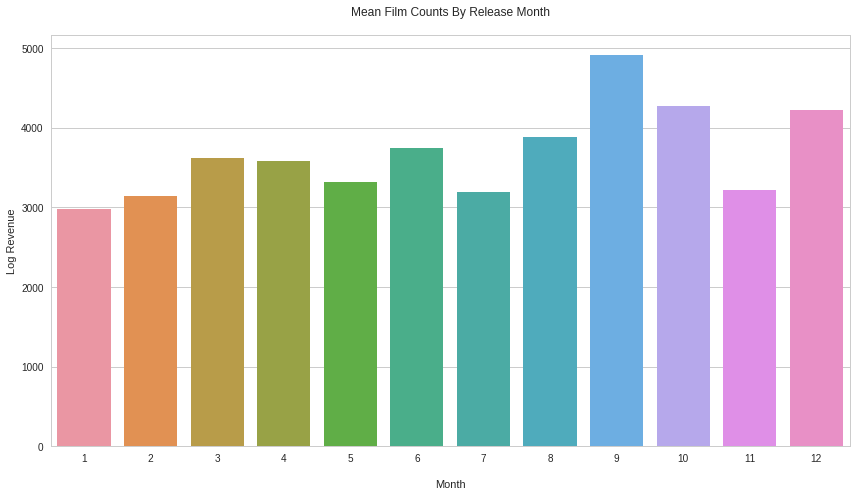

In [28]:
# Exploring film counts per release month
z = df_simp.groupby(by=['month'], as_index=False).sum()

# Plotting
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")
ax = sns.barplot(x=z['month'], y=z['log_revenue'], data=z)
plt.xlabel("\nMonth")
plt.ylabel("Log Revenue")
plt.title("Mean Film Counts By Release Month\n")
plt.tight_layout()
#plt.savefig(".png", dpi =300)
plt.show()

There is definitely a relationship between revenue and the month a film is released. This could be a useful feature.

Based on the findings of the categorical EDA, I will drop the original language feature as well as release year after 2016.

In [29]:
df_simp = df_simp.drop(['original_language'], axis = 1)
df_simp = df_simp[(df_simp['year'] <= 2016)]

df_simp.describe()

,id,budget,popularity,runtime,revenue,month,year,log_budget,log_revenue,log_popularity
count,2509.000000,2.509000e+03,2509.000000,2509.000000,2.509000e+03,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,1502.628537,3.108661e+07,8.403898,108.394580,7.388261e+07,6.786768,2001.649263,16.757384,16.639337,1.903859
std,870.648797,3.520497e+07,5.245715,19.793968,1.373159e+08,3.392865,11.002525,1.086357,2.130090,0.750550
min,1.000000,4.401410e+05,0.609080,40.000000,4.347100e+04,1.000000,1969.000000,12.994850,10.679849,-0.495806
25%,755.000000,1.200000e+07,5.063701,95.000000,5.080409e+06,4.000000,1994.000000,16.300417,15.440902,1.622098
50%,1501.000000,2.253133e+07,7.781790,105.000000,2.270706e+07,7.000000,2004.000000,16.930418,16.938187,2.051786
75%,2262.000000,3.500000e+07,11.184385,118.000000,8.355787e+07,10.000000,2011.000000,17.370859,18.241050,2.414519
max,3000.000000,3.800000e+08,53.291601,338.000000,1.506249e+09,12.000000,2016.000000,19.755682,21.132889,3.975779


In [30]:
df_simp.head()

,id,budget,overview,popularity,runtime,title,revenue,month,year,log_budget,log_revenue,log_popularity
0,1,14000000,"When Lou, who has become the ""father of the In...",6.575393,93,Hot Tub Time Machine 2,12314651,2,2015,16.454568,16.326300,1.883334
1,2,40000000,Mia Thermopolis is now a college graduate and ...,8.248895,113,The Princess Diaries 2: Royal Engagement,95149435,8,2004,17.504390,18.370959,2.110079
3,4,1200000,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,122,Kahaani,16000000,3,2012,13.997832,16.588099,1.155287
4,5,22531334,Marine Boy is the story of a former national s...,1.148070,118,Marine Boy,3923970,2,2009,16.930418,15.182614,0.138082
5,6,8000000,"Pinocchio and his friends, a glow worm and a m...",0.743274,83,Pinocchio and the Emperor of the Night,3261638,8,1987,15.894952,14.997740,-0.296691


In [85]:
import re

# Functions to add binary categorical
def is_sequel(inputString):
    if any(char.isdigit() for char in inputString) == True:
        return 1
    else:
        return 0
      
df_simp['is_seq'] = df_simp.title.apply(is_sequel)

df_simp.head()

,id,budget,overview,popularity,runtime,title,revenue,month,year,log_budget,log_revenue,log_popularity,is_seq
0,1,14000000,"When Lou, who has become the ""father of the In...",6.575393,93,Hot Tub Time Machine 2,12314651,2,2015,16.454568,16.326300,1.883334,1
1,2,40000000,Mia Thermopolis is now a college graduate and ...,8.248895,113,The Princess Diaries 2: Royal Engagement,95149435,8,2004,17.504390,18.370959,2.110079,1
3,4,1200000,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,122,Kahaani,16000000,3,2012,13.997832,16.588099,1.155287,0
4,5,22531334,Marine Boy is the story of a former national s...,1.148070,118,Marine Boy,3923970,2,2009,16.930418,15.182614,0.138082,0
5,6,8000000,"Pinocchio and his friends, a glow worm and a m...",0.743274,83,Pinocchio and the Emperor of the Night,3261638,8,1987,15.894952,14.997740,-0.296691,0


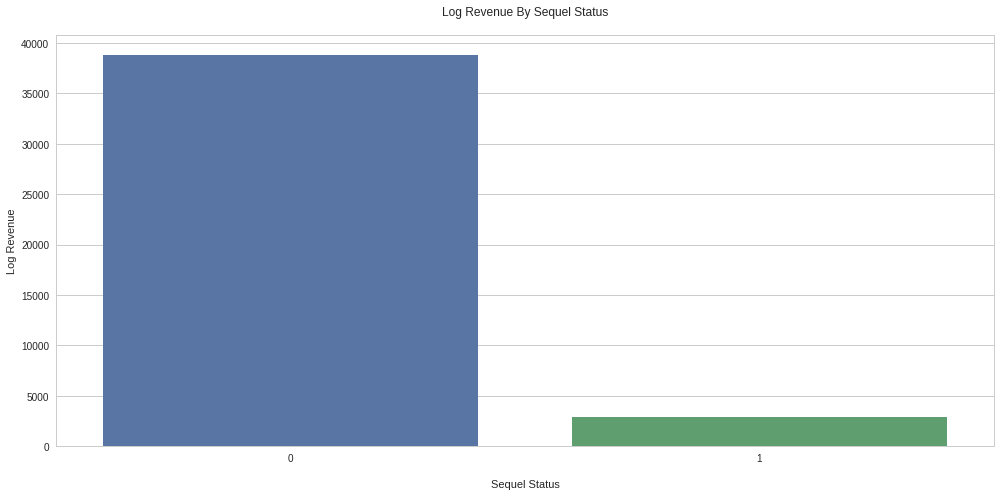

In [103]:
# Exploring film counts released per year

# We need to remove unreleased films
z = df_simp.groupby(by=['is_seq'], as_index=False).sum()

plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")
ax = sns.barplot(x=z['is_seq'], y=z['log_revenue'], data=z)
plt.xlabel("\nSequel Status")
plt.xticks(rotation=0)
plt.ylabel("Log Revenue")
plt.title("Log Revenue By Sequel Status\n")
plt.tight_layout()
#plt.savefig("Counts By Language.png", dpi =300)
plt.show()

# **Principal Component Analysis**

In [86]:
features = df_simp
to_drop = ['id', 'popularity', 'budget', 'overview', 'title', 'revenue']
features = features.drop(to_drop, axis = 1)

features.head()

,runtime,month,year,log_budget,log_revenue,log_popularity,is_seq
0,93,2,2015,16.454568,16.326300,1.883334,1
1,113,8,2004,17.504390,18.370959,2.110079,1
3,122,3,2012,13.997832,16.588099,1.155287,0
4,118,2,2009,16.930418,15.182614,0.138082,0
5,83,8,1987,15.894952,14.997740,-0.296691,0


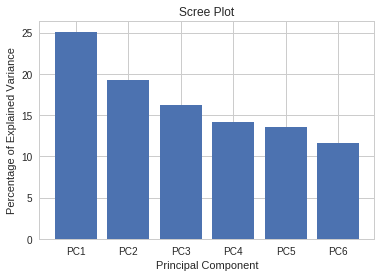

In [87]:
# PCA from 5 features to 5 PCs
from sklearn.decomposition import PCA
from sklearn import preprocessing

#Defining X and Y
X = features.loc[
    :, (features.columns != 'log_revenue')]
y = features['log_revenue']

X_scaled = pd.DataFrame(preprocessing.scale(
    X), index=X.index, columns=X.columns)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

pca = PCA(n_components=6)
pc = pca.fit_transform(X_scaled)
principalDf = pd.DataFrame(data=pc)

# The following code constructs the Scree plot
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

# Machine Learning - Continuous Variables Only 

In [0]:
# Setting up variables for ML

## PCA Variables ##
X_pc = pc[:, 0:2]

X_train_pc, X_test_pc, y_train_pc, y_test_pc = train_test_split(
    X_pc, y, test_size=0.2, random_state=42)

## Raw Variables ##
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [0]:
# Defining cross-validation parameters.
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Defining a function to fit and predict ML algorithms
def auto_model(mod, model_name, X_train, X_test, y_train, y_test):
    #Track Runtime
    t0 = time()
    mod.fit(X_train, y_train)
    modfit = mod.fit(X_train, y_train)
    print(model_name)
    print("done in %0.3fs" % (time() - t0))
    
    #Inspect the results.
    print('Accuracy Score: \n', modfit.score(X_test, y_test))

    # Cross validation
    score = cross_val_score(modfit, X, y, cv=cv)
    print("\nMean (SD) Cross Validation Score: %0.2f (+/- %0.2f)" %
          (score.mean(), score.std() * 2))
    print('\nCross Validation Scores:')
    print(score)
    
# Defining a function to fit and predict ML algorithms
def auto_model_nhb(mod, model_name, X, y):
    #Track Runtime
    t0 = time()
    mod.fit(X, y)
    modfit = mod.fit(X, y)
    print(model_name)
    print("done in %0.3fs" % (time() - t0))
    
    #Inspect the results.
    print('Accuracy Score: \n', modfit.score(X, y))

    # Cross validation
    score = cross_val_score(modfit, X, y, cv=cv)
    print("\nMean (SD) Cross Validation Score: %0.2f (+/- %0.2f)" %
          (score.mean(), score.std() * 2))
    print('\nCross Validation Scores:')
    print(score)    

# **Regression - No Holdback**

In [90]:
# Linear Regression
regr = linear_model.LinearRegression()
auto_model_nhb(regr, "OLS Regression", X, y)

OLS Regression
done in 0.012s
Accuracy Score: 
 0.38733637254520276

Mean (SD) Cross Validation Score: 0.39 (+/- 0.09)

Cross Validation Scores:
[0.45535627 0.40684037 0.39453349 0.32211298 0.36171223]


In [91]:
# Lasso Regression
lass = linear_model.Lasso(alpha=.35)
auto_model_nhb(lass, "Lasso Regression", X, y)

Lasso Regression
done in 0.010s
Accuracy Score: 
 0.3235856966625885

Mean (SD) Cross Validation Score: 0.31 (+/- 0.06)

Cross Validation Scores:
[0.34710518 0.34417402 0.32226954 0.28756429 0.2655085 ]


In [92]:
# Ridge Regression
ridgeregr = linear_model.Ridge(alpha=.5, fit_intercept=True)
auto_model_nhb(ridgeregr, "Ridge Regression", X, y)

Ridge Regression
done in 0.013s
Accuracy Score: 
 0.3873363178473589

Mean (SD) Cross Validation Score: 0.39 (+/- 0.09)

Cross Validation Scores:
[0.45532139 0.40682013 0.39450981 0.32215038 0.36166906]


In [93]:
# Random Forest Regression
rfr = ensemble.RandomForestRegressor()
auto_model_nhb(rfr, "Random Forest Regression", X, y)

Random Forest Regression
done in 0.153s
Accuracy Score: 
 0.9088855700489371

Mean (SD) Cross Validation Score: 0.47 (+/- 0.04)

Cross Validation Scores:
[0.50304279 0.44287198 0.48480004 0.46396651 0.47906674]


# **Regression**

In [94]:
# Linear Regression
regr = linear_model.LinearRegression()
auto_model(regr, "OLS Regression",
           X_train, X_test, y_train, y_test)

OLS Regression
done in 0.005s
Accuracy Score: 
 0.4553562709848879

Mean (SD) Cross Validation Score: 0.39 (+/- 0.09)

Cross Validation Scores:
[0.45535627 0.40684037 0.39453349 0.32211298 0.36171223]


In [95]:
# Lasso Regression
lass = linear_model.Lasso(alpha=.35)
auto_model(lass, "Lasso Regression", 
              X_train, X_test, y_train, y_test)

Lasso Regression
done in 0.008s
Accuracy Score: 
 0.3471051806624271

Mean (SD) Cross Validation Score: 0.31 (+/- 0.06)

Cross Validation Scores:
[0.34710518 0.34417402 0.32226954 0.28756429 0.2655085 ]


In [96]:
# Ridge Regression
ridgeregr = linear_model.Ridge(alpha=.5, fit_intercept=True)
auto_model(ridgeregr, "Ridge Regression", 
           X_train, X_test, y_train, y_test)

Ridge Regression
done in 0.008s
Accuracy Score: 
 0.45532138914693954

Mean (SD) Cross Validation Score: 0.39 (+/- 0.09)

Cross Validation Scores:
[0.45532139 0.40682013 0.39450981 0.32215038 0.36166906]


In [97]:
# Random Forest Regression
rfr = ensemble.RandomForestRegressor()
auto_model(rfr, "Random Forest Regression",
          X_train, X_test, y_train, y_test)

Random Forest Regression
done in 0.129s
Accuracy Score: 
 0.49024440150261384

Mean (SD) Cross Validation Score: 0.46 (+/- 0.05)

Cross Validation Scores:
[0.48346648 0.42025082 0.49437174 0.44082384 0.45208671]


# **PCA Regression**

In [98]:
# Linear Regression
regr = linear_model.LinearRegression()
auto_model(regr, "OLS Regression",
           X_train_pc, X_test_pc, y_train_pc, y_test_pc)

OLS Regression
done in 0.004s
Accuracy Score: 
 0.33977273843206524

Mean (SD) Cross Validation Score: 0.39 (+/- 0.09)

Cross Validation Scores:
[0.45535627 0.40684037 0.39453349 0.32211298 0.36171223]


In [99]:
# Lasso Regression
lass = linear_model.Lasso(alpha=.35)
auto_model(lass, "Lasso Regression", 
              X_train_pc, X_test_pc, y_train_pc, y_test_pc)

Lasso Regression
done in 0.003s
Accuracy Score: 
 0.28571903972361634

Mean (SD) Cross Validation Score: 0.31 (+/- 0.06)

Cross Validation Scores:
[0.34710518 0.34417402 0.32226954 0.28756429 0.2655085 ]


In [100]:
# Ridge Regression
ridgeregr = linear_model.Ridge(alpha=.5, fit_intercept=True)
auto_model(ridgeregr, "Ridge Regression", 
           X_train_pc, X_test_pc, y_train_pc, y_test_pc)

Ridge Regression
done in 0.005s
Accuracy Score: 
 0.33975411808392286

Mean (SD) Cross Validation Score: 0.39 (+/- 0.09)

Cross Validation Scores:
[0.45532139 0.40682013 0.39450981 0.32215038 0.36166906]


In [101]:
# Random Forest Regression
rfr = ensemble.RandomForestRegressor()
auto_model(rfr, "Random Forest Regression",
          X_train_pc, X_test_pc, y_train_pc, y_test_pc)

Random Forest Regression
done in 0.099s
Accuracy Score: 
 0.17141543684905303

Mean (SD) Cross Validation Score: 0.45 (+/- 0.07)

Cross Validation Scores:
[0.48319556 0.38780047 0.45230489 0.48126417 0.46384079]
